<a href="https://colab.research.google.com/github/RVasconcelosMiguel/ComputerVision/blob/main/CV_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tqdm

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import zipfile

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [4]:
import zipfile

#Limpa arquivos existentes do sistema antes de iniciar as operações.
!rm -f -r "images"
!rm -f "module_metadada.json"

#Definição de caminhos
download_path = "/content/InfraredSolarModules/"
download_path_file = "/content/InfraredSolarModules/2020-02-14_InfraredSolarModules.zip"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

# Clonar o repositorio e fazer unzip
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $download_path
!mv $download_path_file $extract_path
!unzip -uq $zip_path -d $extract_path

# Imagens
image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

# module_metadata.json
metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

#Remoção de arquivos desnecessários
!rm -f $zip_path
!rm -f -r $download_path
!rm -r "__MACOSX"

Cloning into '/content/InfraredSolarModules'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 10), reused 12 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 5.49 MiB | 8.46 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [5]:
classes_a = ("anomaly", "no-anomaly")
classes_b=("cell","cell-multi","cracking","hotspot","hot-spot-multi","shadowing","diode","diode-multi","vegetation","soiling","offlinemodule")
classes_c=("cell","cell-multi","cracking","hotspot","hot-spot-multi","shadowing","diode","diode-multi","vegetation","soiling","offlinemodule","no-anomaly")


metadata_path = '/content/module_metadata.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

metadata_df_a = pd.DataFrame.from_dict(metadata, orient='index')
metadata_df_b = pd.DataFrame.from_dict(metadata, orient='index')
metadata_df_c = pd.DataFrame.from_dict(metadata, orient='index')

metadata_df_a['anomaly_class'] = metadata_df_a['anomaly_class'].apply(lambda x: 'Anomaly' if x != 'No-Anomaly' else 'No-Anomaly')
metadata_df_b = metadata_df_b[metadata_df_b["anomaly_class"] != "No-Anomaly"]

print("---------a) dataframe------------")
print("\n Data \n",metadata_df_a.tail(10))
print("\n Data size :",metadata_df_a.shape[0])
print("\n")

print("---------b) dataframe------------")
print("\n Data \n",metadata_df_b.tail(10))
print("\n Data size :",metadata_df_b.shape[0])
print("\n")

print("---------c) dataframe------------")
print("\n Data \n",metadata_df_c.tail(10))
print("\n Data size :",metadata_df_c.shape[0])
print("\n")

---------a) dataframe------------

 Data 
          image_filepath anomaly_class
8483    images/8483.jpg       Anomaly
8484    images/8484.jpg       Anomaly
8485    images/8485.jpg       Anomaly
8486    images/8486.jpg       Anomaly
8487    images/8487.jpg       Anomaly
8488    images/8488.jpg       Anomaly
8489    images/8489.jpg       Anomaly
7464    images/7464.jpg       Anomaly
18065  images/18065.jpg    No-Anomaly
13354  images/13354.jpg    No-Anomaly

 Data size : 20000


---------b) dataframe------------

 Data 
        image_filepath anomaly_class
8481  images/8481.jpg    Vegetation
8482  images/8482.jpg    Vegetation
8483  images/8483.jpg    Vegetation
8484  images/8484.jpg    Vegetation
8485  images/8485.jpg    Vegetation
8486  images/8486.jpg    Vegetation
8487  images/8487.jpg    Vegetation
8488  images/8488.jpg    Vegetation
8489  images/8489.jpg    Vegetation
7464  images/7464.jpg      Cracking

 Data size : 10000


---------c) dataframe------------

 Data 
          imag

In [6]:
#NO-Anomaly=0 Anomalia=1
metadata_df_a['anomaly_class'] = metadata_df_a['anomaly_class'].apply(lambda x: 1 if x != 'No-Anomaly' else 0)# as anomalias ficam todas Anomaly
print("*************** Alinea a dataframe ***************")
print("\n Dados \n",metadata_df_a.head(20)) # Verificar as primeiras linhas
print("\n numero de linhas :",metadata_df_a.shape[0])
print("\n")

metadata_df_b['anomaly_class'] = metadata_df_b['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11
)
print("*************** Alinea b dataframe ***************")
print("\n Dados \n",metadata_df_b.head(20)) # Verificar as primeiras linhas
print("\n numero de linhas :",metadata_df_b.shape[0])
print("\n")

metadata_df_c['anomaly_class'] = metadata_df_c['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11 if x == 'No-Anomaly'
              else 12
)
print("*************** Alinea c dataframe ***************")
print("\n Dados \n",metadata_df_c.head(20)) # Verificar as primeiras linhas
print("\n numero de linhas :",metadata_df_c.shape[0])
print("\n")

*************** Alinea a dataframe ***************

 Dados 
          image_filepath  anomaly_class
13357  images/13357.jpg              0
13356  images/13356.jpg              0
19719  images/19719.jpg              0
11542  images/11542.jpg              0
11543  images/11543.jpg              0
11540  images/11540.jpg              0
11541  images/11541.jpg              0
11546  images/11546.jpg              0
11547  images/11547.jpg              0
11544  images/11544.jpg              0
11545  images/11545.jpg              0
14545  images/14545.jpg              0
11548  images/11548.jpg              0
11549  images/11549.jpg              0
16426  images/16426.jpg              0
19927  images/19927.jpg              0
5988    images/5988.jpg              1
5989    images/5989.jpg              1
19399  images/19399.jpg              0
19398  images/19398.jpg              0

 numero de linhas : 20000


*************** Alinea b dataframe ***************

 Dados 
        image_filepath  anomaly

<ipython-input-6-52b512ad38d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df_b['anomaly_class'] = metadata_df_b['anomaly_class'].apply(


In [7]:
train_data, test_data=train_test_split(metadata_df_a, test_size=0.15,train_size=0.85, random_state=2, stratify=metadata_df_a["anomaly_class"])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

ESTÁ IGUAL AO DO VITOR TEMOS QUE MUDAR DAQUI PARA BAIXO

In [8]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [9]:
# Transformações
transform = transforms.Compose([

    transforms.ToTensor(),  # Converte para tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliza
])

# Datasets
train_dataset = MyImageDataset(metadata=train_data, transform=transform)
test_dataset = MyImageDataset(metadata=test_data, transform=transform)

# DataLoaders
batch_size = 32
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



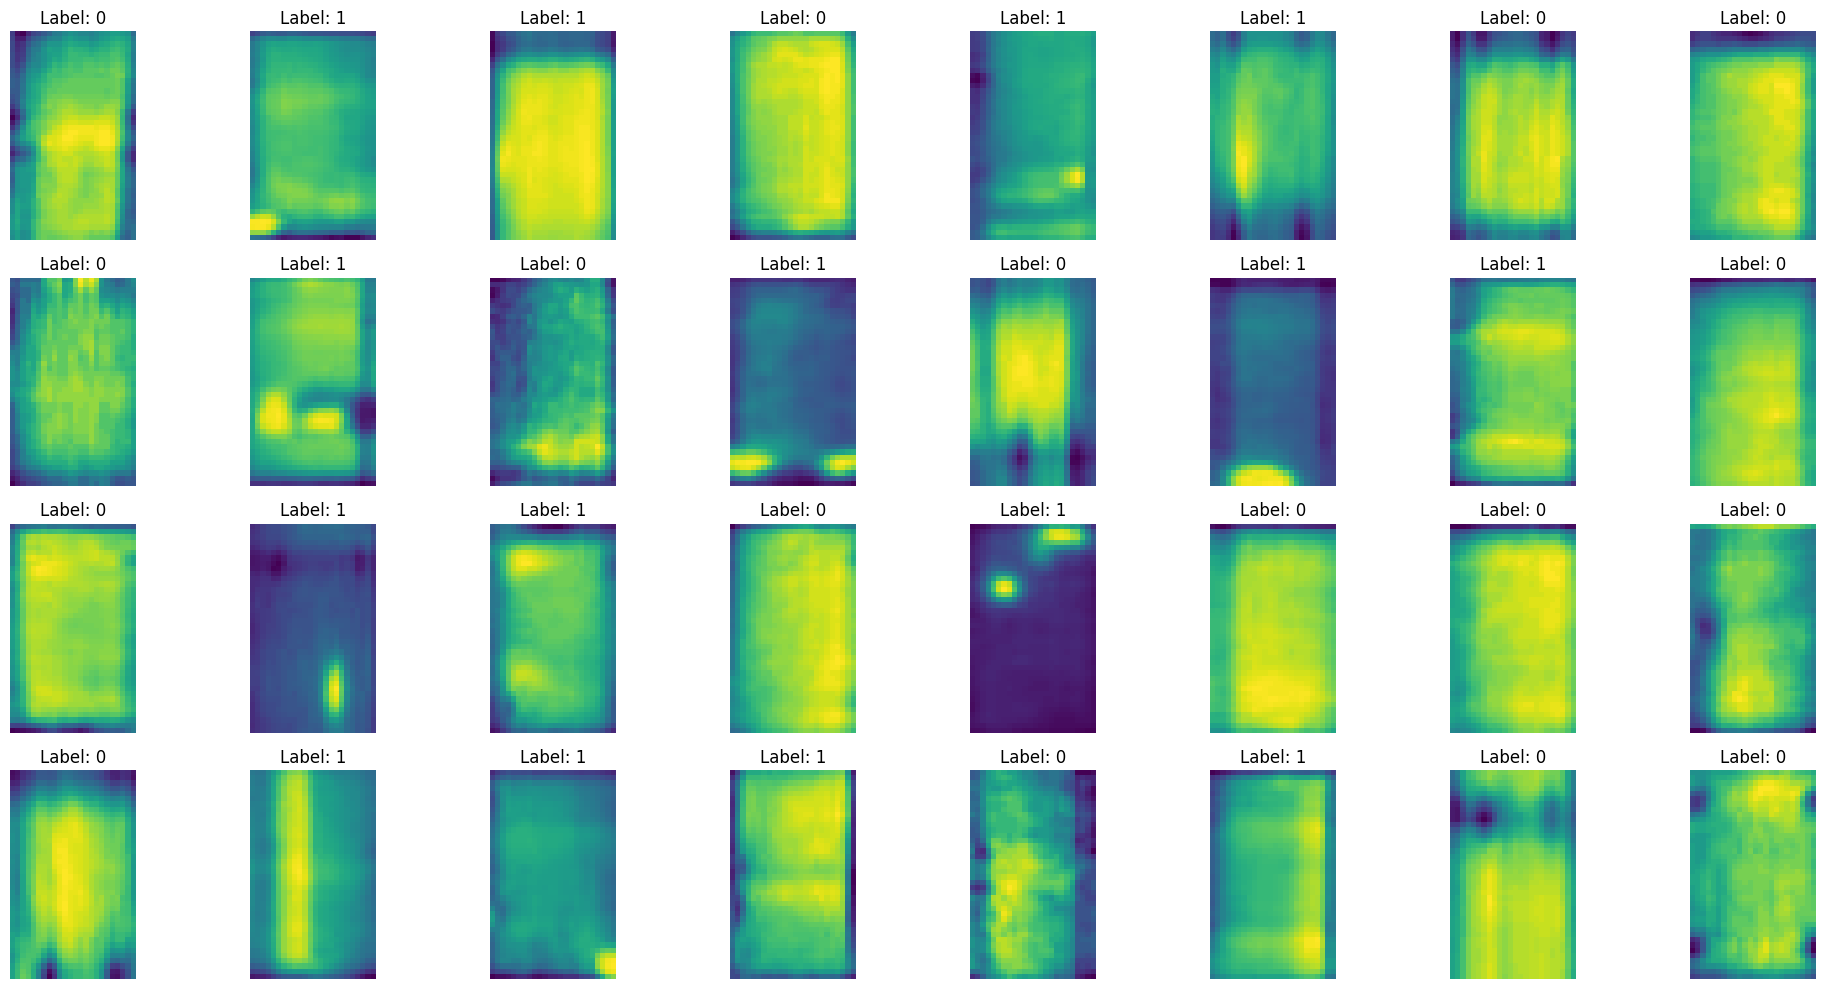

In [10]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images, labels = next(iter(train_loader))  # Pega o primeiro batch

# Desfazendo a normalização para as imagens
images = images * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images)):
    image = images[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()







In [11]:
#Mesmo da prática
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Camadas convolucionais e de pooling
        self.conv1 = nn.Conv2d(1, 64, 5)  # Tem de ser assim o 1 e
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3)  # Tamanho esperado: [128, 18, 34] (kernel 3x3)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)  # Tamanho esperado após pool1: [128, 9, 17] (redução pelo max pool)
        self.conv3 = nn.Conv2d(128, 256, 3)  # Tamanho esperado: [256, 7, 15] (kernel 3x3)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3)  # Tamanho esperado: [512, 5, 13] (kernel 3x3)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool2 = nn.MaxPool2d(2, 2)  # Tamanho esperado após pool2: [512, 2, 6] (redução pelo max pool)

        # Calculando a entrada correta para a camada fully connected (Linear)
        self.fc1 = nn.Linear(512 * 2 * 6, 1024)  # O valor de 512*2*6 vem das dimensões finais após a convolução
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, 2)  # 2 saidas , deixar o 2 pq sao apenas duas saidas mas nos restantes é 11 e 12

    def forward(self, x):
        # Passa pela primeira camada convolucional, ReLU, e pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))

        # Passa pela segunda camada convolucional, ReLU e pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))


        # Achata a saída para a camada Linear
        x = torch.flatten(x, 1)  # Achata para [batch_size, 512*2*6]

        # Passa pelas camadas Fully Connected e Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)

        return x
model = Network()
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9)

In [12]:
from torch.autograd import Variable

# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):  # Adicionando a barra de progresso para os epochs

        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader):  # Adicionando a barra de progresso para os batches

            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # 1. Forward pass
            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        # we want to save the model if the accuracy is the best


        if train_acc > best_accuracy:
            path = str(path_model)
            saveModel(model, path = path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    return best_loss, best_accuracy, best_epoch

In [13]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):

    # Put model in eval mode
    model.eval()
    model.to(device)
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item()/len(y_pred)
            pred_labels = y_pred_class.tolist()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    if verbatim:
      print("Loss =", test_loss, "  Accuracy=", test_acc)
    return pred_labels, test_loss, test_acc


In [14]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader=train_loader,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 20,
                                                    path_model = str("./myModel_best_A.pth"),
                                                    verbatim = True)

Epochs:   5%|▌         | 1/20 [00:30<09:39, 30.51s/epoch]

Best Epoch # 0  Loss= 0.5162723805839405  Accu= 0.7410126879699248


Epochs:  10%|█         | 2/20 [00:43<06:08, 20.48s/epoch]

Best Epoch # 1  Loss= 0.4005613546062233  Accu= 0.8243656015037594


Epochs:  15%|█▌        | 3/20 [00:57<04:54, 17.33s/epoch]

Best Epoch # 2  Loss= 0.3525206109971032  Accu= 0.8526785714285714


Epochs:  20%|██        | 4/20 [01:11<04:14, 15.90s/epoch]

Best Epoch # 3  Loss= 0.3226784320786259  Accu= 0.8668937969924813


Epochs:  25%|██▌       | 5/20 [01:25<03:47, 15.14s/epoch]

Best Epoch # 4  Loss= 0.29807256150962713  Accu= 0.8772321428571429


Epochs:  30%|███       | 6/20 [01:38<03:24, 14.58s/epoch]

Best Epoch # 5  Loss= 0.28363390084832235  Accu= 0.8887453007518797


Epochs:  35%|███▌      | 7/20 [01:52<03:05, 14.23s/epoch]

Best Epoch # 6  Loss= 0.26540582122883405  Accu= 0.8939144736842105


Epochs:  40%|████      | 8/20 [02:06<02:53, 14.42s/epoch]

Best Epoch # 7  Loss= 0.24771165076111043  Accu= 0.9017857142857143


Epochs:  45%|████▌     | 9/20 [02:20<02:35, 14.16s/epoch]

Best Epoch # 8  Loss= 0.2364409329103572  Accu= 0.9098331766917294


Epochs:  55%|█████▌    | 11/20 [02:47<02:04, 13.79s/epoch]

Best Epoch # 10  Loss= 0.21506243998086766  Accu= 0.9156484962406015


Epochs:  60%|██████    | 12/20 [03:00<01:49, 13.72s/epoch]

Best Epoch # 11  Loss= 0.1976990061567018  Accu= 0.9251057330827067


Epochs:  65%|██████▌   | 13/20 [03:14<01:35, 13.68s/epoch]

Best Epoch # 12  Loss= 0.19052364041370556  Accu= 0.9271616541353384


Epochs:  75%|███████▌  | 15/20 [03:41<01:07, 13.57s/epoch]

Best Epoch # 14  Loss= 0.17405505722766756  Accu= 0.9330944548872181


Epochs:  80%|████████  | 16/20 [03:54<00:54, 13.53s/epoch]

Best Epoch # 15  Loss= 0.15939029775335825  Accu= 0.9384985902255639


Epochs:  85%|████████▌ | 17/20 [04:08<00:40, 13.52s/epoch]

Best Epoch # 16  Loss= 0.15351444557379174  Accu= 0.9419055451127819


Epochs:  90%|█████████ | 18/20 [04:21<00:26, 13.45s/epoch]

Best Epoch # 17  Loss= 0.15558620422546351  Accu= 0.9429628759398496


Epochs:  95%|█████████▌| 19/20 [04:34<00:13, 13.41s/epoch]

Best Epoch # 18  Loss= 0.13818438247518433  Accu= 0.948484492481203


Epochs: 100%|██████████| 20/20 [04:48<00:00, 14.42s/epoch]

Best Epoch # 19  Loss= 0.13339887778239704  Accu= 0.9497767857142857


In [15]:
y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=test_loader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    verbatim = True)

Loss = 0.2571817261582993   Accuracy= 0.9215425531914894
